### Imports

In [1]:
import numpy as np
import pandas as pd 
from collections import Counter
import os
import glob
import copy
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

### Read the ATN profiles 

In [133]:
gmm = pd.read_csv("../gmm/final_profiles_gmm.csv", index_col=0)
kmeans = pd.read_csv("../k_means/final_profiles_kmeans.csv", index_col=0)
tertile = pd.read_csv("../tertile/final_profiles_tertile.csv", index_col=0)
roc = pd.read_csv("../roc/final_profiles_roc.csv", index_col=0)
mean_sd = pd.read_csv("../mean_std/final_profiles_mean_std.csv", index_col=0)

In [134]:
mean_sd

,A-T-N-,A-T+N+,A-T-N+,A-T+N-,A+T+N-,A+T-N-,A+T-N+,A+T+N+
ADNI,813,154,20,22,0,7,0,1
EPAD,1165,49,9,4,0,10,0,0
PREVENT-AD,123,5,1,1,0,3,0,0
NACC,385,35,43,13,2,17,2,9
EMIF,742,117,70,33,1,31,15,5
DOD-ADNI,106,5,1,1,0,0,0,0
JADNI,119,48,8,4,3,10,1,4


In [141]:
patients_ = dict(gmm.sum(axis=1))

### Data preparation

In [83]:
def normalize_atns(df):
    'normalize the atn profiles'
    
    for coh in df.index:
        df.loc[coh] = (df.loc[coh]/sum(df.loc[coh]))
        

In [84]:
normalize_atns(gmm)
normalize_atns(kmeans)
normalize_atns(tertile)
normalize_atns(roc)
normalize_atns(mean_sd)

In [85]:
gmm['method'] = 'gmm'
kmeans['method'] = 'kmeans'
tertile['method'] = 'tertile'
roc['method'] = 'roc'
mean_sd['method'] = 'mean_sd'

In [86]:
print(roc.index.difference(tertile.index))
roc.index # not all methods were applied for all cohorts

Index([], dtype='object')


Index(['ADNI', 'EMIF', 'EPAD', 'JADNI', 'NACC'], dtype='object')

In [87]:
profiles_all = pd.concat([gmm, kmeans, tertile, roc, mean_sd])

In [90]:
atn_dict = dict()
for coh in profiles_all.index.unique():
    coh_prof = dict()
    
    for col in profiles_all.columns.difference(['method']):
        coh_prof[col] = profiles_all.loc[coh][col].to_list()
    
    atn_dict[coh] = coh_prof

In [11]:
atn_dict['ADNI'].keys()

dict_keys(['A+T+N+', 'A+T+N-', 'A+T-N+', 'A+T-N-', 'A-T+N+', 'A-T+N-', 'A-T-N+', 'A-T-N-'])

In [12]:
def create_plot_input(my_dict):
    """transform input data into a list of tuples of form (middle, error)"""
    
    cohort_bars = dict()

    for coh in my_dict:
        bars = list()
        atn_order = ['A-T-N-', 'A-T+N+', 'A-T-N+', 'A-T+N-', 'A+T+N-', 'A+T-N-', 'A+T-N+', 'A+T+N+']
        
        for prof in atn_order:
            middle = ((np.max(my_dict[coh][prof]) - np.min(my_dict[coh][prof]))/2) + np.min(my_dict[coh][prof])
            err = (np.max(my_dict[coh][prof]) - np.min(my_dict[coh][prof]))/2         
#             print(coh, middle, err)         
            bars.append((middle, err))
                                                               
        cohort_bars[coh] = bars
    return cohort_bars

In [13]:
bars_dict = create_plot_input(atn_dict)

In [14]:
# for x_pos, bar in enumerate(bars_dict['JADNI']):
#     print(x_pos, bar)

In [15]:
# for i in gmm.index: 
#     if i not in tertile.index.union(roc.index):
#         print(i)

In [16]:
tertile.index.difference(roc.index)

Index(['DOD-ADNI', 'PREVENT-AD'], dtype='object')

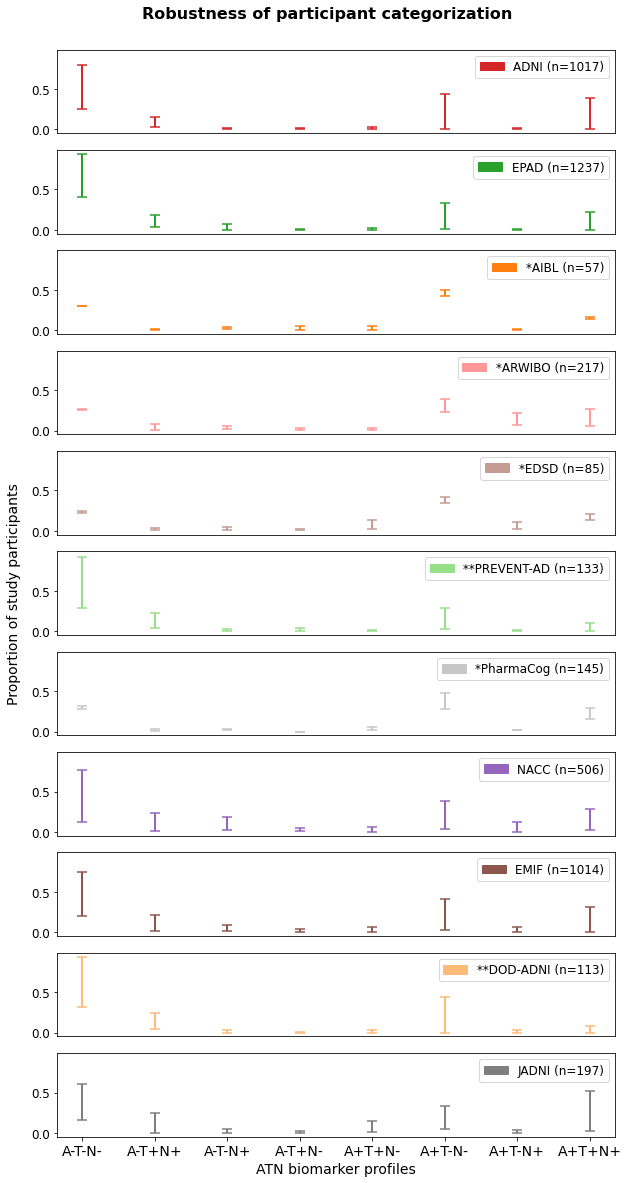

In [144]:
caps = 5
markersize = 4
capthick = 1.5
lw = 2
line_y = 0
subtitle_fontsize = 12
x_tick_alignment = "center"
x_tick_rotation = 0
# xlim = (-0.09,5)
colors = {'ADNI': '#d62728', 'AIBL': '#ff7f0e', 'EPAD': '#2ca02c', 
          'NACC': '#9467bd', 'EMIF': '#8c564b', 'JADNI': '#7f7f7f', 
          'DOD-ADNI': '#ffbb78', 'PREVENT-AD': '#98df8a', 'ARWIBO': '#ff9896', 
          'EDSD': '#c49c94', 'PharmaCog': '#c7c7c7'}

fig, axes = plt.subplots(11, 1, sharey=True, figsize=(10, 20))
fig.suptitle(f"Robustness of participant categorization", weight="bold", ha="center", fontsize=16, y=.91)

for i, coh in enumerate(bars_dict):
    for x_pos, bar in enumerate(bars_dict[coh]):
        axes[i].errorbar(y=bar[0], x=x_pos, yerr=(bar[1]), capsize=caps, marker="", 
                         linestyle="", color=colors[coh], 
                         markersize=markersize, capthick=capthick, lw=lw)
        axes[i].set_xticks([])
        axes[i].tick_params(axis="x", which='major', labelsize=14)
        axes[i].tick_params(axis="y", which='major', labelsize=12)
#         axes[i].set_title(f"{coh}", loc="center", fontsize=subtitle_fontsize)
        
        if coh not in tertile.index.union(roc.index):
            axes[i].legend(handles=[mpatches.Patch(color=colors[coh], label=f"*{coh} (n={patients_[coh]})")], loc="upper right", fontsize=12)
        
        elif coh in tertile.index.difference(roc.index):
            axes[i].legend(handles=[mpatches.Patch(color=colors[coh], label=f"**{coh} (n={patients_[coh]})")], loc="upper right", fontsize=12)

        else:
            axes[i].legend(handles=[mpatches.Patch(color=colors[coh], label=f"{coh} (n={patients_[coh]})")], loc="upper right", fontsize=12)

    
axes[10].set_xticks(list(range(8)))
axes[10].set_xticklabels(labels=['A-T-N-', 'A-T+N+', 'A-T-N+', 'A-T+N-', 'A+T+N-', 'A+T-N-', 'A+T-N+', 'A+T+N+'], ha=x_tick_alignment, fontsize=14)
axes[10].set_xlabel('ATN biomarker profiles', fontsize=14)
axes[5].set_ylabel('Proportion of study participants', fontsize=14, labelpad=10)


# plt.tight_layout()
plt.savefig("profiles.png", dpi=400, bbox_inches='tight')

###  Read all cutoff tables

In [12]:
tables = [pd.read_csv(file, index_col=0, low_memory=False) for file in sorted(glob.glob('../cutoffs/' + "/*."+'csv'))]
methods = [file.split(".")[0] for file in sorted(os.listdir('../cutoffs/'))]

In [13]:
methods

['cutoffs_cohort_study',
 'gmm_baseline_cutoffs',
 'gmm_cutoffs',
 'km_cutoffs',
 'mean_std_cutoffs',
 'roc_cutoffs',
 'tertile_cutoffs']

In [14]:
# make a dictionary that contains all cutoff tables as a dataframe
cutoff_tables = dict()

for tab, meth in zip(tables, methods):
    cutoff_tables[meth] = tab

In [15]:
# select the relevant methods to plot
cutoffs = dict()

# methods_order = ['gmm_cutoffs', 'km_cutoffs', 'mean_std_cutoffs', 'tertile_cutoffs', 'roc_cutoffs', 'cutoffs_cohort_study']

for i in methods:
    if i not in ['gmm_baseline_cutoffs']:
        cutoffs[i] = cutoff_tables[i]

In [16]:
cutoffs['cutoffs_cohort_study'] = cutoffs['cutoffs_cohort_study'][~cutoffs['cutoffs_cohort_study'].index.isin(['EDSD', 'EMIF'])].dropna()

In [17]:
# convert values to float
for i in cutoffs['cutoffs_cohort_study'].columns:
    cutoffs['cutoffs_cohort_study'][i] = cutoffs['cutoffs_cohort_study'][i].astype(float)

In [18]:
for i in cutoffs:
    cutoffs[i]['method'] = i

In [19]:
#rename columns before combining the dataframes 
for i in cutoffs['km_cutoffs'].columns:
    cutoffs['km_cutoffs'].rename(columns={i: i.split('_')[0]}, inplace=True)

In [20]:
thresholds = pd.concat(cutoffs.values())

In [72]:
thresholds.loc['EPAD']

,A-beta 1-42 in CSF,pTau in CSF,tTau in CSF,method
EPAD,1034.92,27.74,306.69,gmm_cutoffs
EPAD,1030.74,19.84,223.56,km_cutoffs
EPAD,337.89,43.34,436.41,mean_std_cutoffs
EPAD,731.50,20.90,213.80,roc_cutoffs
EPAD,882.97,19.90,228.27,tertile_cutoffs


### Which method often results in lowest/highest thresholds?

In [381]:
trend_max = pd.DataFrame(index=thresholds.index.unique(), columns=thresholds.columns[:-1])
trend_min = pd.DataFrame(index=thresholds.index.unique(), columns=thresholds.columns[:-1])
heatmap_df_method = {i: pd.DataFrame(index=thresholds.index.unique(), columns=set(thresholds['method'].unique()).difference(['cutoffs_cohort_study'])) for i in thresholds.columns[:-1]}
heatmap_df_method_order = pd.DataFrame(index=thresholds.index.unique(), columns=set(thresholds['method'].unique()).difference(['cutoffs_cohort_study']))
# heatmap_df_csf = pd.DataFrame(index=thresholds.index.unique(), columns=set(thresholds['method'].unique()).difference(['cutoffs_cohort_study']))

In [382]:
# create a dictionary of dictionary where keys are CSF and values are dataframes
heatmaps = {i: pd.DataFrame(index=thresholds.index.unique(), 
            columns=set(thresholds['method'].unique()).difference(['cutoffs_cohort_study'])) 
            for i in thresholds.columns[:-1]}


for i in heatmaps: heatmaps[i].replace({np.nan: 0}, inplace=True)

In [383]:
cutoffs_five_method = thresholds[thresholds['method']!='cutoffs_cohort_study']

In [389]:
# Rank the methods that were feasible by 2  

for bioma__ in heatmap_df_method:
    
    for i in cutoffs_five_method.index: 
        for met in cutoffs_five_method.loc[i]['method'].to_list():
            
            heatmap_df_method[bioma__].loc[i, met] = 2

In [391]:
for i in cutoffs_five_method.index.unique():
    df = cutoffs_five_method.loc[i]
    
    for col in df.columns[:-1]:
        trend_max.loc[i, col] = df.loc[df[col]==df[col].max()]['method'].item()
        trend_min.loc[i, col] = df.loc[df[col]==df[col].min()]['method'].item()
        heatmap_df_method[col].loc[i, df.loc[df[col]==df[col].max()]['method'].item()] = 3 # maximum threshold
        heatmap_df_method[col].loc[i, df.loc[df[col]==df[col].min()]['method'].item()] = 1 # minimum threshold
        
        for num, met in zip(list(np.arange(1, 6)), cutoffs_five_method.loc[i].sort_values(by=col)['method'].to_list()):
            heatmaps[col].loc[i, met] = num # method that were not perform will remain 0

In [392]:
for i in heatmap_df_method:
    heatmap_df_method[i].rename(columns={'mean_std_cutoffs': 'Mean ±2 SD', 'gmm_cutoffs': 'GMM', 
                              'roc_cutoffs': 'ROC', 'km_cutoffs': 'K-Means', 
                              'tertile_cutoffs': 'Tertile'}, index={'NACC_ELISA': 'NACC ELISA', 
                              'NACC_XMAP': 'NACC XMAP', 'EMIF_ELISA': 'EMIF ELISA', 
                              'EMIF_XMAP': 'EMIF XMAP'}, inplace=True)
    
    heatmap_df_method[i] = heatmap_df_method[i].loc[['ADNI', 'EPAD', 'AIBL', 'ARWIBO', 'EDSD', 
            'PREVENT-AD', 'PharmaCog', 'NACC ELISA', 'EMIF ELISA', 'NACC XMAP', 'EMIF XMAP', 
            'DOD-ADNI', 'JADNI']]
    heatmap_df_method[i] = heatmap_df_method[i][['GMM', 'K-Means', 'Tertile', 'ROC', 'Mean ±2 SD']]

In [393]:
# heatmap_df_method['A-beta 1-42 in CSF']

In [394]:
# heatmap_df_method_order.replace({np.nan: 0}, inplace=True)

In [395]:
for i in heatmaps:
    heatmaps[i].rename(columns={'mean_std_cutoffs': 'Mean ±2 SD', 'gmm_cutoffs': 'GMM', 
                              'roc_cutoffs': 'ROC', 'km_cutoffs': 'K-Means', 
                              'tertile_cutoffs': 'Tertile'}, inplace=True)

In [396]:
heatmap_df_method['A-beta 1-42 in CSF']

,GMM,K-Means,Tertile,ROC,Mean ±2 SD
ADNI,3,2,2,2,1
EPAD,3,2,2,2,1
AIBL,3,1,NaN,NaN,NaN
ARWIBO,3,1,NaN,NaN,NaN
EDSD,1,3,NaN,NaN,NaN
PREVENT-AD,2,3,2,NaN,1
PharmaCog,3,1,NaN,NaN,NaN
NACC ELISA,2,2,3,2,1
EMIF ELISA,3,2,2,2,1
NACC XMAP,3,2,2,2,1


In [397]:
heatmaps['A-beta 1-42 in CSF']

,Mean ±2 SD,GMM,ROC,K-Means,Tertile
ADNI,1,5,2,4,3
AIBL,0,2,0,1,0
DOD-ADNI,1,4,0,3,2
JADNI,1,5,2,4,3
PharmaCog,0,2,0,1,0
EPAD,1,5,2,4,3
ARWIBO,0,2,0,1,0
EDSD,0,1,0,2,0
PREVENT-AD,1,2,0,4,3
NACC_ELISA,1,4,2,3,5


A-beta 1-42 in CSF
pTau in CSF
tTau in CSF


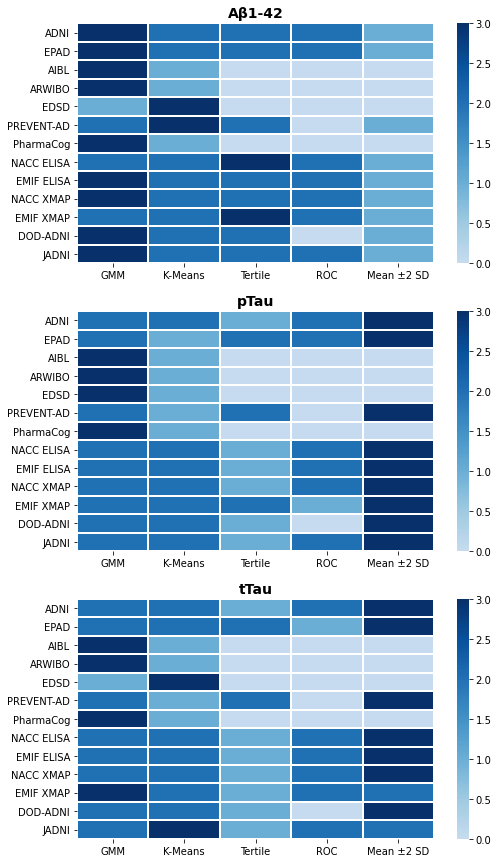

In [412]:
cmap=['#f2f7ff','#568ae3', '#0040a6']
# cmap = ['#f5f9fc', '#d0e1f0', '#abcae4', '#86b2d8', '#619bcc', '#3d84bf', '#316a9a']
csf_names = {'A-beta 1-42 in CSF': 'Aβ1-42', 'pTau in CSF': 'pTau', 'tTau in CSF': 'tTau'}

fig, axes = plt.subplots(3, 1, figsize=(8, 15))

for i, j in enumerate(heatmaps):
    print(j)
    sns.heatmap(heatmap_df_method[j].replace({np.nan: 0}), cmap='Blues', center=1, linewidths=1.5, ax=axes[i])
    axes[i].set_title(csf_names[j], weight="bold", fontsize=14)
    
plt.savefig("trend_methods.png", dpi=400, bbox_inches='tight')

A-beta 1-42 in CSF
pTau in CSF
tTau in CSF


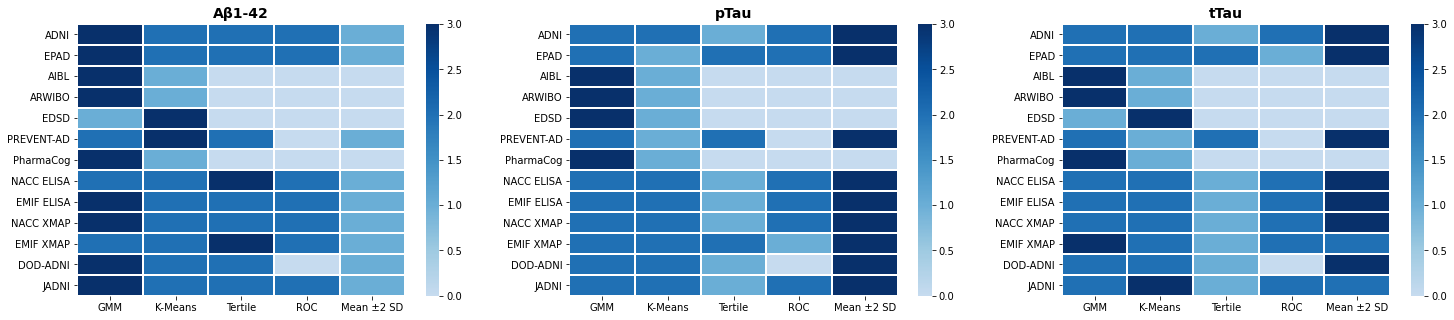

In [417]:
cmap=['#f2f7ff','#568ae3', '#0040a6']
# cmap = ['#f5f9fc', '#d0e1f0', '#abcae4', '#86b2d8', '#619bcc', '#3d84bf', '#316a9a']
csf_names = {'A-beta 1-42 in CSF': 'Aβ1-42', 'pTau in CSF': 'pTau', 'tTau in CSF': 'tTau'}

fig, axes = plt.subplots(1, 3, figsize=(25, 5))

for i, j in enumerate(heatmaps):
    print(j)
    sns.heatmap(heatmap_df_method[j].replace({np.nan: 0}), cmap='Blues', center=1, linewidths=1.5, ax=axes[i])
    axes[i].set_title(csf_names[j], weight="bold", fontsize=14)
    
plt.savefig("trend_methods_horizontal.png", dpi=400, bbox_inches='tight')

In [403]:
# # cmap=['#f2f7ff','#568ae3', '#0040a6']
# # cmap = ['#f5f9fc', '#d0e1f0', '#abcae4', '#86b2d8', '#619bcc', '#3d84bf', '#316a9a']
# csf_names = {'A-beta 1-42 in CSF': 'Aβ1-42', 'pTau in CSF': 'pTau', 'tTau in CSF': 'tTau'}

# fig, axes = plt.subplots(1, 3, figsize=(20, 4))

# for i, j in enumerate(heatmaps):
#     print(j)
#     sns.heatmap(heatmaps[j], cmap='Blues', center=1, linewidths=1.5, ax=axes[i])
#     axes[i].set_title(csf_names[j])
    
# # plt.savefig("trend_methods.png", dpi=400, bbox_inches='tight')

In [404]:
# # cmap=['#f2f7ff','#568ae3', '#0040a6']
# # cmap = ['#f5f9fc', '#d0e1f0', '#abcae4', '#86b2d8', '#619bcc', '#3d84bf', '#316a9a']
# csf_names = {'A-beta 1-42 in CSF': 'Aβ1-42', 'pTau in CSF': 'pTau', 'tTau in CSF': 'tTau'}

# fig, axes = plt.subplots(3, 1, figsize=(6, 15))

# for i, j in enumerate(heatmaps):
#     print(j)
#     sns.heatmap(heatmaps[j], cmap='Blues', center=1, linewidths=1.5, ax=axes[i])
#     axes[i].set_title(csf_names[j])
    
# # plt.savefig("trend_methods_test.png", dpi=400, bbox_inches='tight')

In [362]:
for i in trend_max.columns:
    print(i, Counter(trend_max[i]))

A-beta 1-42 in CSF Counter({'gmm_cutoffs': 9, 'km_cutoffs': 2, 'tertile_cutoffs': 2})
pTau in CSF Counter({'mean_std_cutoffs': 9, 'gmm_cutoffs': 4})
tTau in CSF Counter({'mean_std_cutoffs': 7, 'gmm_cutoffs': 4, 'km_cutoffs': 2})


In [144]:
for i in trend_min.columns:
    print(i, Counter(trend_min[i]))

A-beta 1-42 in CSF Counter({'mean_std_cutoffs': 9, 'km_cutoffs': 3, 'gmm_cutoffs': 1})
pTau in CSF Counter({'tertile_cutoffs': 6, 'km_cutoffs': 6, 'roc_cutoffs': 1})
tTau in CSF Counter({'tertile_cutoffs': 7, 'km_cutoffs': 4, 'roc_cutoffs': 1, 'gmm_cutoffs': 1})


In [104]:
trend_max

,A-beta 1-42 in CSF,pTau in CSF,tTau in CSF
ADNI,gmm_cutoffs,mean_std_cutoffs,mean_std_cutoffs
AIBL,gmm_cutoffs,gmm_cutoffs,gmm_cutoffs
DOD-ADNI,gmm_cutoffs,mean_std_cutoffs,mean_std_cutoffs
JADNI,gmm_cutoffs,mean_std_cutoffs,km_cutoffs
PharmaCog,gmm_cutoffs,gmm_cutoffs,gmm_cutoffs
EPAD,gmm_cutoffs,mean_std_cutoffs,mean_std_cutoffs
ARWIBO,gmm_cutoffs,gmm_cutoffs,gmm_cutoffs
EDSD,km_cutoffs,gmm_cutoffs,km_cutoffs
PREVENT-AD,km_cutoffs,mean_std_cutoffs,mean_std_cutoffs
NACC_ELISA,tertile_cutoffs,mean_std_cutoffs,mean_std_cutoffs


In [106]:
trend_min

,A-beta 1-42 in CSF,pTau in CSF,tTau in CSF
ADNI,mean_std_cutoffs,tertile_cutoffs,tertile_cutoffs
AIBL,km_cutoffs,km_cutoffs,km_cutoffs
DOD-ADNI,mean_std_cutoffs,tertile_cutoffs,tertile_cutoffs
JADNI,mean_std_cutoffs,tertile_cutoffs,tertile_cutoffs
PharmaCog,km_cutoffs,km_cutoffs,km_cutoffs
EPAD,mean_std_cutoffs,km_cutoffs,roc_cutoffs
ARWIBO,km_cutoffs,km_cutoffs,km_cutoffs
EDSD,gmm_cutoffs,km_cutoffs,gmm_cutoffs
PREVENT-AD,mean_std_cutoffs,km_cutoffs,km_cutoffs
NACC_ELISA,mean_std_cutoffs,tertile_cutoffs,tertile_cutoffs


In [105]:
heatmap_df

,mean_std_cutoffs,gmm_cutoffs,roc_cutoffs,km_cutoffs,tertile_cutoffs
ADNI,2,2,NaN,NaN,1
AIBL,NaN,2,NaN,1,NaN
DOD-ADNI,2,2,NaN,NaN,1
JADNI,2,2,NaN,2,1
PharmaCog,NaN,2,NaN,1,NaN
EPAD,2,2,1,1,NaN
ARWIBO,NaN,2,NaN,1,NaN
EDSD,NaN,1,NaN,2,NaN
PREVENT-AD,2,NaN,NaN,1,NaN
NACC_ELISA,2,NaN,NaN,NaN,1


In [66]:
thresholds.head()

,A-beta 1-42 in CSF,pTau in CSF,tTau in CSF,method
ADNI,980.0,21.8,245.0,cutoffs_cohort_study
AIBL,1054.0,213.0,21.3,cutoffs_cohort_study
DOD-ADNI,515.0,87.3,436.0,cutoffs_cohort_study
JADNI,333.0,45.0,93.0,cutoffs_cohort_study
PharmaCog,550.0,61.0,190.0,cutoffs_cohort_study


### Plot the thresholds 

In [28]:
for i in thresholds.columns[:-1]: 
    thresholds.rename(columns={i: i.split(" in")[0]}, inplace=True)
    
thresholds.rename(columns={'A-beta 1-42': 'Aβ1-42'}, inplace=True)

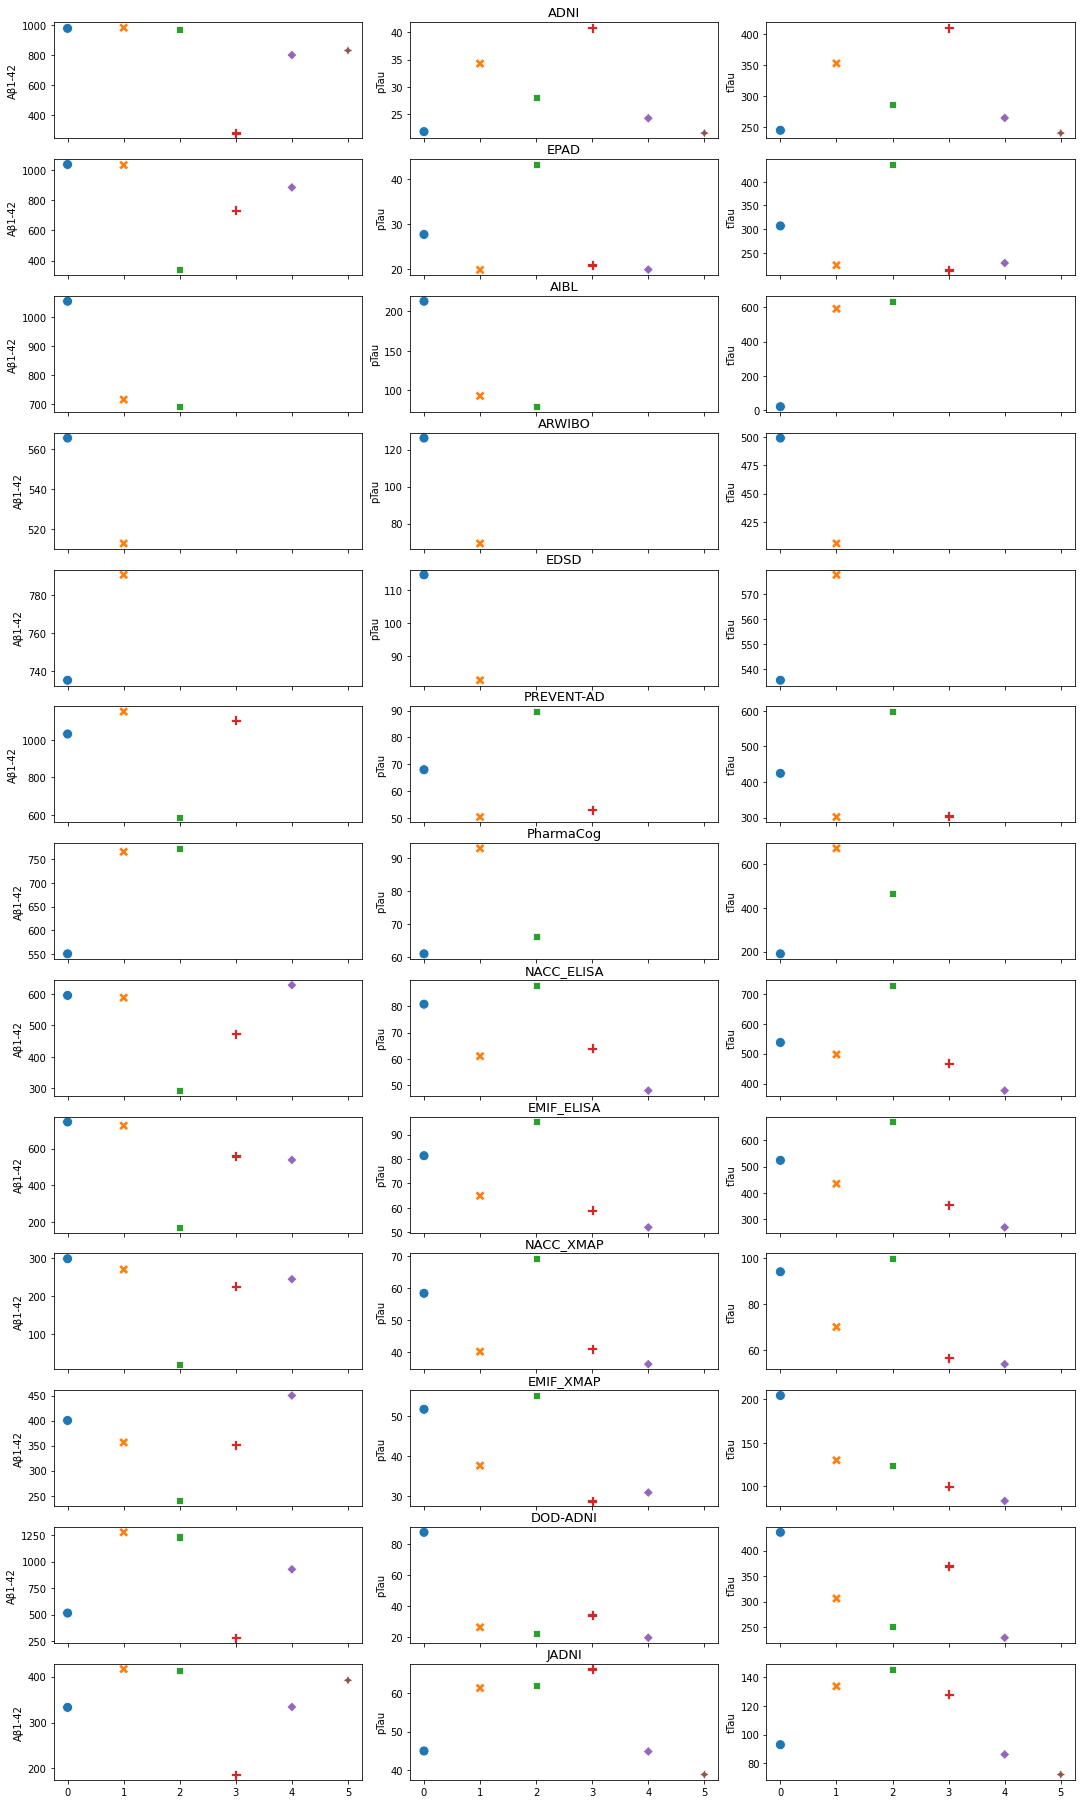

In [30]:
cohort_order= ['ADNI', 'EPAD', 'AIBL', 'ARWIBO', 'EDSD', 'PREVENT-AD', 'PharmaCog',
       'NACC_ELISA', 'EMIF_ELISA', 'NACC_XMAP',
       'EMIF_XMAP', 'DOD-ADNI', 'JADNI']

fig, axes = plt.subplots(13, 3, sharex=True, figsize=(15, 25))
fig.tight_layout()
# fig.subplots_adjust(hspace=0.7)
i=0

for ind in cohort_order:
    
    for bioma, location in zip(thresholds.columns[:-1], range(3)):

        sns.scatterplot(x=range(len(thresholds.loc[ind, bioma])), y=thresholds.loc[ind, bioma], hue=thresholds.loc[ind, 'method'], 
                        ax=axes[i, location], legend=False, style=thresholds.loc[ind, 'method'], s=100)
        
        axes[i, location].grid(False)
        axes[i, location].set_xlabel('')
#         axes[i, location].set_ylabel('')
#         axes[i, location].set_title(bioma, fontsize=12)
        axes[i, 1].set_title(ind, fontsize=13)
    
    i+=1
    
# plt.savefig("thresholds.png", dpi=400, bbox_inches='tight')

['cutoffs_cohort_study', 'gmm_cutoffs', 'km_cutoffs', 'mean_std_cutoffs', 'roc_cutoffs', 'tertile_cutoffs']


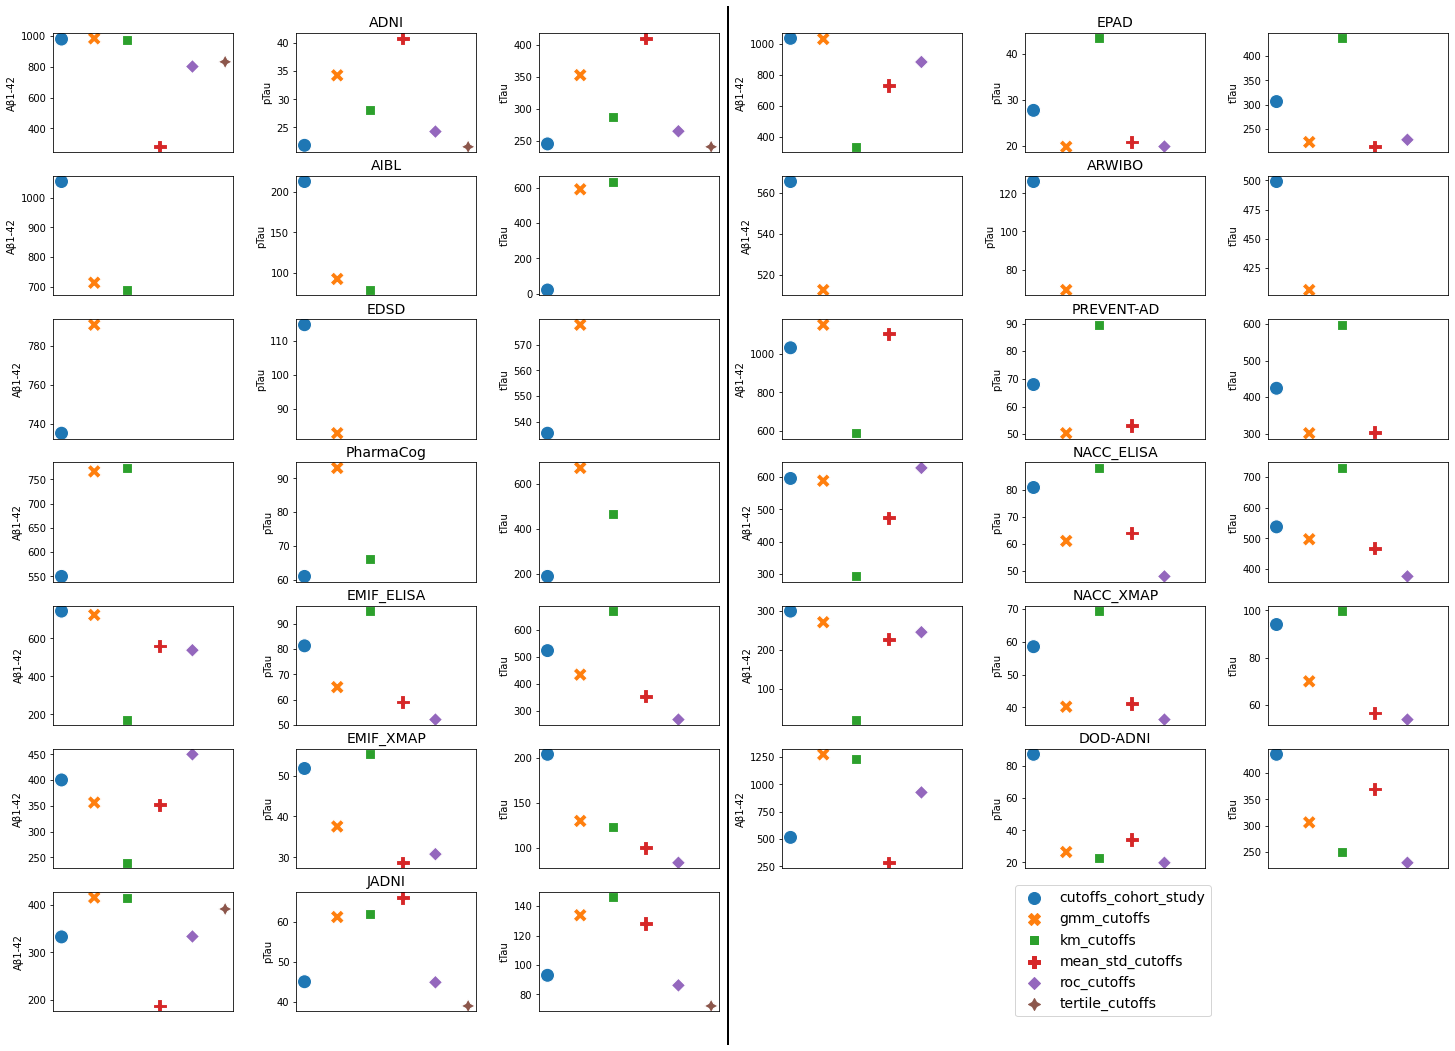

In [68]:
cohort_order= ['ADNI', 'EPAD', 'AIBL', 'ARWIBO', 'EDSD', 'PREVENT-AD', 'PharmaCog',
       'NACC_ELISA', 'EMIF_ELISA', 'NACC_XMAP',
       'EMIF_XMAP', 'DOD-ADNI', 'JADNI']

fig, axes = plt.subplots(7, 6, sharex=True, figsize=(25, 18))
fig.subplots_adjust(hspace=.2, wspace=.35)
# fig.tight_layout()
i=0
flag=1


method_names = {'cutoffs_cohort_study': 'Study-suggested', 'gmm_baseline_cutoffs': 'GMM baseline model', 
     'km_cutoffs': 'K-Means', 'mean_std_cutoffs': 'Mean ± SD', 
     'roc_cutoffs': 'ROC', 'tertile_cutoffs': 'Tertile', 'gmm_cutoffs': 'GMM'}

for ind in cohort_order:
    
    if flag==1:
        
        for bioma, location in zip(thresholds.columns[:-1], range(3)):

            sns.scatterplot(x=range(len(thresholds.loc[ind, bioma])), y=thresholds.loc[ind, bioma], hue=thresholds.loc[ind, 'method'], 
                            ax=axes[i, location], style=thresholds.loc[ind, 'method'], s=200)

            axes[i, location].grid(False)
            axes[i, location].set_xlabel('')
#             axes[i, location].set_ylabel('')
            axes[i, location].set_xticks([])
            handles, labels = axes[i, location].get_legend_handles_labels()
            axes[i, location].legend().remove()
            axes[i, 1].set_title(ind, fontsize=14)

        flag+=1
        
        line = plt.Line2D((.5, .5), (.1, .9), color='black', linewidth=2)
        
    else:
        
        for bioma, location in zip(thresholds.columns[:-1], range(3, 6)):

            sns.scatterplot(x=range(len(thresholds.loc[ind, bioma])), y=thresholds.loc[ind, bioma], hue=thresholds.loc[ind, 'method'], 
                            ax=axes[i, location], legend=False, style=thresholds.loc[ind, 'method'], s=200)

            axes[i, location].grid(False)
            axes[i, location].set_xlabel('')
#             axes[i, location].set_ylabel('')
            axes[i, 4].set_title(ind, fontsize=14)

        flag=1
        i+=1

for i in range(3, 6):
    fig.delaxes(axes[6, i])
    
print(labels)

    
plt.legend(handles, labels, loc='lower right', bbox_to_anchor=(3.77, -0.1), fontsize=14, markerscale=2)
fig.add_artist(line)

# fig.subplots_adjust(wspace=2)
    
# plt.savefig("thresholds_2.png", dpi=400, bbox_inches='tight')